In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
from cars_detector.utils  import read_frame, read_test_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features

In [3]:
df_ground_truth = pd.read_csv('./train.csv')

## Sampling of positive and negative examples

In [4]:
total_positive_samples, total_negative_samples = sampling(df_ground_truth)

100%|██████████| 2225/2225 [01:51<00:00, 20.03it/s]


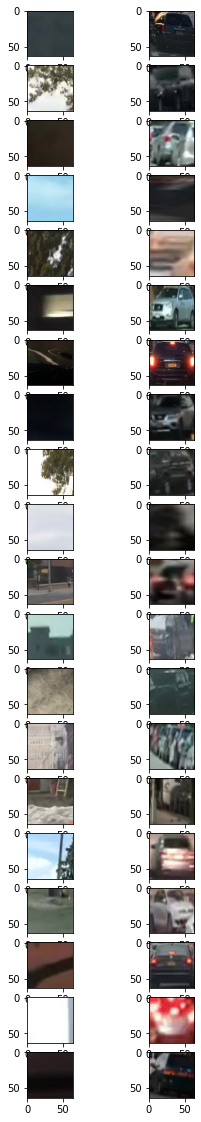

In [5]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [6]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.4
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/21994 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 61842/61842 [00:06<00:00, 9090.54it/s]


In [7]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 30872
number of negative samples: 86533


## Features computation

In [15]:
if os.path.isfile("data/features/positive_features.npy") and os.path.isfile("data/features/negative_features.npy"):
    print('load data')
    positive_features = np.load("data/features/positive_features.npy")
    negative_features = np.load("data/features/negative_features.npy")
else:
    print('compute features')
    positive_features, negative_features = compute_features(total_positive_samples,total_negative_samples)
    positive_features, negative_features = np.array(positive_features), np.array(negative_features)
    np.save("data/features/positive_features.npy", positive_features)
    np.save("data/features/negative_features.npy", negative_features)

load data


In [ ]:
from sklearn.model_selection import train_test_split
X = np.array(positive_features+negative_features)
y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#clf = SVC()
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.917971249413471


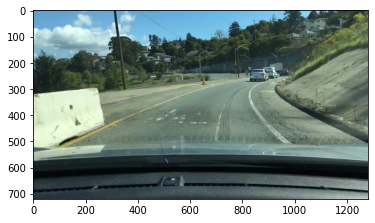

In [ ]:
test_img = read_test_frame(100)
plt.imshow(test_img)

In [ ]:
pred_array = np.zeros((test_img.shape[0], test_img.shape[1]), dtype = float)
crop_pos = []
crop_neg = []
for size in tqdm(range(100,200,20), position = 0):
    for i in range(size, test_img.shape[0], int(size*0.75)):
        for j in range(size, test_img.shape[1], int(size*0.75)):
            crop = test_img[i-size:i, j-size:j,::]
            crop = cv2.resize(crop, (64,64))
            (H, hogImage) = feature.hog(crop, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
            pred = clf.predict([H])
            if pred == 0:
                crop_neg.append(crop)
            else:
                crop_pos.append(crop)
            pred_array[i-size:i, j-size:j] += pred




100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


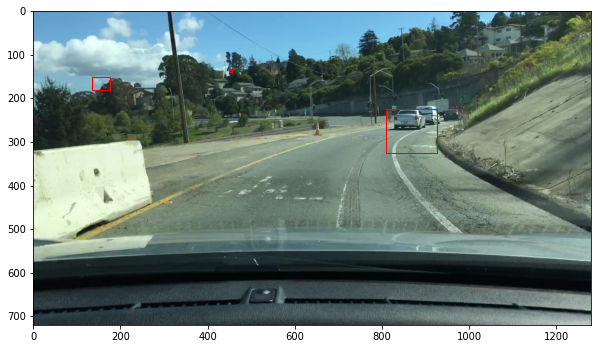

In [ ]:
import cv2

# Grayscale then Otsu's threshold
gray = (pred_array>2).astype("uint8")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
bbs = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    bbs.append([x,y,w,h])

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in bbs:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_img)

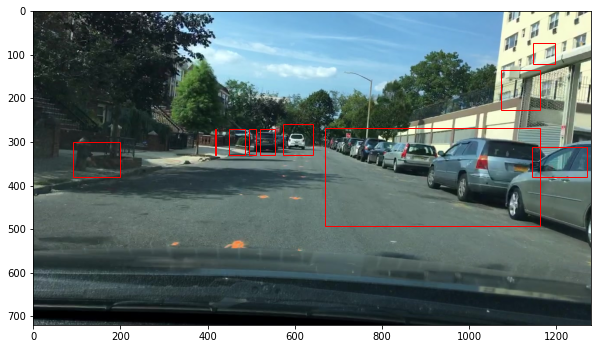

In [ ]:
import cv2

# Grayscale then Otsu's threshold
gray = pred_array.astype("uint8")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
bbs = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    bbs.append([x,y,w,h])

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in bbs:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_img)

In [ ]:
data_root = './train/'

_N = 202 # number of frames

def format_id(frame):
    assert _N >= frame
    return '%03d' % frame

def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return imread(os.path.join(root, format_id(frame)+'.jpg'))

def show_annotation(pos_bbs, neg_bbs, frame):
    assert frame <= _N
    img = read_frame(data_root, frame)

    fig, ax = plt.subplots(figsize=(10, 8))

    for x, y, dx, dy in pos_bbs:
        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    for x, y, dx, dy in neg_bbs:    
        rect = patches.Rectangle((x, y), dx, dy, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

from ipywidgets import interact, widgets
from IPython.display import display

show_annotation(bbs, negative_samples, 1)

NameError: name 'negative_samples' is not defined